In [1]:
import pandas as pd

df = pd.read_csv("../../project/data/S05-hw-dataset.csv")
# Это мы загружаем таблицу
df.head()
df.info()
df.describe()
df["default"].value_counts(normalize=True)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3000 entries, 0 to 2999
Data columns (total 17 columns):
 #   Column                          Non-Null Count  Dtype  
---  ------                          --------------  -----  
 0   client_id                       3000 non-null   int64  
 1   age                             3000 non-null   int64  
 2   income                          3000 non-null   int64  
 3   years_employed                  3000 non-null   int64  
 4   credit_score                    3000 non-null   int64  
 5   debt_to_income                  3000 non-null   float64
 6   num_credit_cards                3000 non-null   int64  
 7   num_late_payments               3000 non-null   int64  
 8   has_mortgage                    3000 non-null   int64  
 9   has_car_loan                    3000 non-null   int64  
 10  savings_balance                 3000 non-null   int64  
 11  checking_balance                3000 non-null   int64  
 12  region_risk_score               30

default
0    0.589667
1    0.410333
Name: proportion, dtype: float64

In [2]:
# признаки и таргет
X = df.drop(columns=["default", "client_id"])
y = df["default"]

In [3]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(
    X, y,
    test_size=0.2,
    random_state=42,
    stratify=y
)

In [4]:
from sklearn.dummy import DummyClassifier
from sklearn.metrics import accuracy_score, roc_auc_score
# DummyClassifier всегда предсказывает наиболее частый класс и используется как простейшая точка отсчёта качества модели.
dummy = DummyClassifier(strategy="most_frequent")
dummy.fit(X_train, y_train)

y_pred_dummy = dummy.predict(X_test)
y_proba_dummy = dummy.predict_proba(X_test)[:, 1]

acc_dummy = accuracy_score(y_test, y_pred_dummy)
auc_dummy = roc_auc_score(y_test, y_proba_dummy)

acc_dummy, auc_dummy

(0.59, 0.5)

In [5]:
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression

pipe = Pipeline([
    ("scaler", StandardScaler()),
    ("logreg", LogisticRegression(max_iter=1000))
])

In [6]:
Cs = [0.01, 0.1, 1.0, 10.0]
results = []

for C in Cs:
    pipe.set_params(logreg__C=C)
    pipe.fit(X_train, y_train)

    y_pred = pipe.predict(X_test)
    y_proba = pipe.predict_proba(X_test)[:, 1]

    results.append({
        "C": C,
        "accuracy": accuracy_score(y_test, y_pred),
        "roc_auc": roc_auc_score(y_test, y_proba)
    })

results_df = pd.DataFrame(results)
results_df

,C,accuracy,roc_auc
0,0.01,0.806667,0.875442
1,0.10,0.801667,0.875477
2,1.00,0.800000,0.875614
3,10.00,0.800000,0.875637


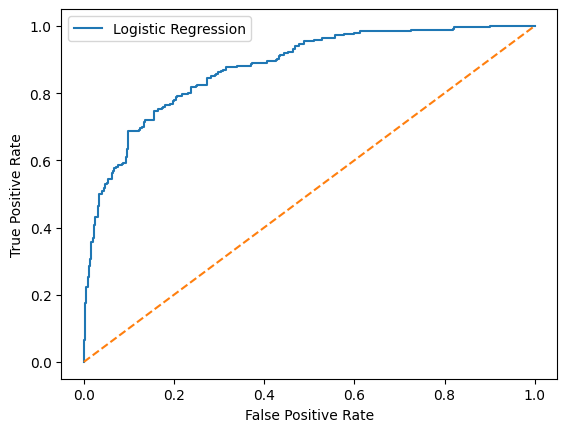

In [7]:
from sklearn.metrics import roc_curve
import matplotlib.pyplot as plt

fpr, tpr, _ = roc_curve(y_test, y_proba)

plt.figure()
plt.plot(fpr, tpr, label="Logistic Regression")
plt.plot([0, 1], [0, 1], "--")
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.legend()
plt.savefig("figures/roc_curve.png")
plt.show()

In [8]:
comparison = pd.DataFrame({
    "model": ["DummyClassifier", "LogisticRegression"],
    "accuracy": [acc_dummy, results_df["accuracy"].max()],
    "roc_auc": [auc_dummy, results_df["roc_auc"].max()]
})

comparison

,model,accuracy,roc_auc
0,DummyClassifier,0.590000,0.500000
1,LogisticRegression,0.806667,0.875637
